# Short-time Fourier Transformation
on audio files

## Read WAV signals
- signal information and sample plot

https://docs.scipy.org/doc/scipy/reference/signal.html

In [51]:
# LOAD AUDIO DATASET
import os
import numpy as np
from sklearn import datasets

PARAM_RND_STATE = 42

container_path = os.path.join ('..', '..', 'src_audio')
load_content = False
description = ['key C, mode minor', 'key C, mode major',
               'key C#, mode minor', 'key C#, mode major',
               'key D, mode minor', 'key D, mode major',
               'key D#, mode minor', 'key D#, mode major',
               'key E, mode minor', 'key E, mode major',
               'key F, mode minor', 'key F, mode major',
               'key F#, mode minor', 'key F#, mode major',
               'key G, mode minor', 'key G, mode major',
               'key G#, mode minor', 'key G#, mode major',
               'key A, mode minor', 'key A, mode major',
               'key A#, mode minor', 'key A#, mode major',
               'key B, mode minor', 'key B, mode major']

src_audio_data = datasets.load_files (container_path=container_path,
                                      description=description,
                                      load_content=load_content,
                                      random_state=PARAM_RND_STATE)

In [52]:
src_audio_data.keys ()

dict_keys(['filenames', 'DESCR', 'target', 'target_names'])

In [53]:
src_audio_data['filenames'][0]

'../../src_audio/1-0/TRLZZOJ128F1494C12.wav'

In [54]:
print (src_audio_data['target'], src_audio_data['target'].min (), src_audio_data['target'].max ())
print (src_audio_data['target_names'])

[ 2  0  9 10 10 17 23  8  0 14  4 20 11 16 11 23 18  1 15 12 12  1 23  3
 17 15  1 20 23 15  9 22  2 18  1  6 19  5  7 17 22 11 22  1 15  6 16  3
 13  6 20 18 20 19 22 20 11 21  7 13  9 12 12  6 10  6 10  8 11 19 17 11
  2 12  7  8  0  5 16 15  9  6 21 20 14  3  1  3  2  4 22 14 16  5 13 19
  7  4 16 14  7 14  2 23 21 23 13  0  0  7  4 10 11 14 17  9  8 16 15  9
  3 14  6  2 11 15 19  3  1 23  2 14  0 12  3 13 17  6 13 12 21 18  7 18
  6  4 15  4 12  2 17 19  8  3 20  4  9 18  4 14 22  0 10  5 13 21 18 22
  4 16  8  3  0 17 11  9  8 21 21  8  0  1  5 20 13  1 16  7 22 13 19 22
  6  5 10  5 19 17 19 18 23 21 16  5  4  8  2  5 20 16 23 18 19 12  3 15
 22  0  5 14 13 15 10  9 11  8 20  7 21 21 12 23  2 18  7 10  1  9 17 10] 0 23
['0-0', '0-1', '1-0', '1-1', '10-0', '10-1', '11-0', '11-1', '2-0', '2-1', '3-0', '3-1', '4-0', '4-1', '5-0', '5-1', '6-0', '6-1', '7-0', '7-1', '8-0', '8-1', '9-0', '9-1']


In [45]:
# READ WAVE FILES and store their information in a pandas df
import os
import numpy as np
import pandas as pd
from scipy.io import wavfile

audio_data_list = list ()

for audio_file in src_audio_data['filenames']:    
    sig_fs, sig = wavfile.read (audio_file)

    sig_ch = len (sig.shape) # number of channels
    sig_N = sig.shape[0] # number of samples
    sig_nw = sig.dtype.itemsize # sample width
    sig_len = sig_N/sig_fs # length of signal
    
    audio_data_list.append ([sig_fs, sig_ch, sig_N, sig_nw, sig_len, sig])

columns = ['sig_fs', 'sig_ch', 'sig_N', 'sig_nw', 'sig_len', 'sig']
audio_data_df = pd.DataFrame (audio_data_list, columns=columns)

/home/ubudan/ml/keyestcnn/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


explanation of columns:
- *sig_fs* = sampling rate (samples per second)
- *sig_ch* = number of channels
- *sig_N* = number of samples
- *sig_nw* = sample width (bytes)
- *sig_len* = length of signal (seconds)
- *sig* = signal data (array of samples)

In [65]:
display (audio_data_df.sample (3))

,sig_fs,sig_ch,sig_N,sig_nw,sig_len,sig
195,44100,2,1323000,2,30.000000,"[[581, 469], [662, 565], [711, 629], [725, 647..."
187,44100,2,1323000,2,30.000000,"[[-1872, -1004], [-1981, -1133], [-1499, -707]..."
130,44100,2,1323225,2,30.005102,"[[804, -145], [864, -69], [968, 40], [1067, 12..."


[i] Example
signal information:
  channels: 2
  sampling rate: 44100 Hz (S/s)
  number of samples: 1323000 S
  sample width: 2 Bytes = 16 Bits
  length of signal: 30.00 s


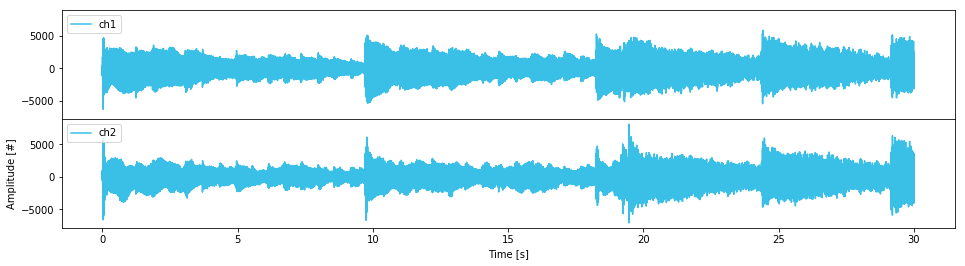

In [136]:
# FYI: EXAMPLE
import matplotlib.pyplot as plt
%matplotlib inline

print ('[i] Example')

ex_signal = audio_data_df.iloc[42]
sig_ch = ex_signal['sig_ch']
sig_fs = ex_signal['sig_fs']
sig_N = ex_signal['sig_N']
sig_nw = ex_signal['sig_nw']
sig_len = ex_signal['sig_len']
sig = ex_signal['sig']

print ('signal information:')
print ('  channels:', sig_ch)
print ('  sampling rate: {} Hz (S/s)'.format (sig_fs))
print ('  number of samples: {} S'.format (sig_N))
print ('  sample width: {} Bytes = {} Bits'.format (sig_nw, sig_nw*8))
print ('  length of signal: {:.2f} s'.format (sig_len))


# plot sample of wav file
t = np.linspace (0, len (sig)/sig_fs, sig_N)

fig, axs = plt.subplots (2, 1, sharex=True, sharey=True)

axs[0].step (t, sig[:,0], c="#3ABFE7", label='ch1')
axs[0].legend (loc='upper left')

axs[1].step (t, sig[:,1], c="#3ABFE7", label='ch2')
axs[1].legend (loc='upper left')

_ = plt.ylim()
fig.set_size_inches ((16., 4.), forward=True)
fig.suptitle ('')
fig.subplots_adjust (hspace=0)

plt.xlabel('Time [s]')
plt.ylabel('Amplitude [#]')

plt.show()

## Data Preprocessing
consists of:
- reducing signal to one channel (mono)
- decimation of signal (apply low-pass filter and downsampling)
  - parameter: decimation factor = 2

In [108]:
from scipy import signal

PARAM_DEC_FAC = 2

def sig_prep (sig, sig_ch=2, sig_fs=44100):
    
    sig_prep = np.copy (sig)
    
    #print ('>>> reducing signal to one channel...', end=' ', flush=True)
    if sig_ch == 2:
        sig_prep = sig_prep.sum (axis=1) / 2
    #print ('done')

    #print ('>>> decimation of signal to (factor {})...'.format (PARAM_DEC_FAC), end=' ', flush=True)
    sig_prep = signal.decimate (sig_prep, q=PARAM_DEC_FAC, ftype='fir').astype (dtype=sig.dtype, copy=False)
    #print ('done')

    sig_ch = len (sig_prep.shape)
    sig_N = sig_prep.shape[0]
    sig_nw = sig_prep.dtype.itemsize
    sig_fs = int (sig_fs / PARAM_DEC_FAC)
    sig_len = sig_N/sig_fs
    
    return ([sig_fs, sig_ch, sig_N, sig_nw, sig_len, sig_prep])

In [110]:
audio_data_prep_list = list ()

i = 0
z = len (audio_data_list)
for (sig_fs, sig_ch, _, _, _, sig) in audio_data_list:
    print ('\r>>> preprocessing signal {} of {}...'.format (i+1, z), end=' ')
    sig_p = sig_prep (sig, sig_ch, sig_fs)
    audio_data_prep_list.append (sig_p)
    i+=1

audio_data_prep_df = pd.DataFrame (audio_data_prep_list, columns=columns)
print ('done')

>>> preprocessing signal 5 of 240... 

/home/ubudan/ml/keyestcnn/lib/python3.5/site-packages/scipy/signal/signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
/home/ubudan/ml/keyestcnn/lib/python3.5/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


>>> preprocessing signal 240 of 240... done


In [121]:
display (audio_data_prep_df.sample (3))

,sig_fs,sig_ch,sig_N,sig_nw,sig_len,sig
24,22050,1,661500,2,30.0,"[3, 6, 8, 7, 8, 3, -11, -9, 8, 7, 8, 8, 8, 8, ..."
157,22050,1,661500,2,30.0,"[1136, 3572, 5452, 6325, 6453, 6084, 5109, 515..."
78,22050,1,661500,2,30.0,"[-2198, -2711, -2906, -3408, -4359, -5324, -48..."


[i] Example
signal information:
  channels: 1
  sampling rate: 22050 Hz (S/s)
  number of samples: 661500 S
  sample width: 2 Bytes = 16 Bits
  length of signal: 30.00 s


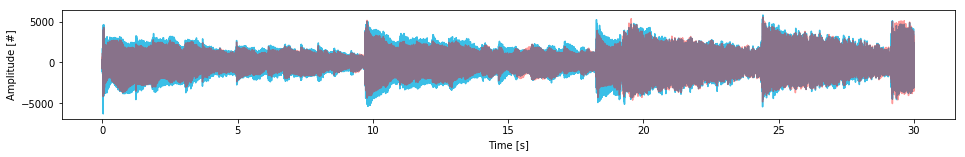

In [137]:
# FYI: EXAMPLE
print ('[i] Example')

ex_signal_p = audio_data_prep_df.iloc[42]
sig_ch_p = ex_signal_p['sig_ch']
sig_fs_p = ex_signal_p['sig_fs']
sig_N_p = ex_signal_p['sig_N']
sig_nw_p = ex_signal_p['sig_nw']
sig_len_p = ex_signal_p['sig_len']
sig_p = ex_signal_p['sig']

print ('signal information:')
print ('  channels:', sig_ch_p)
print ('  sampling rate: {} Hz (S/s)'.format (sig_fs_p))
print ('  number of samples: {} S'.format (sig_N_p))
print ('  sample width: {} Bytes = {} Bits'.format (sig_nw_p, sig_nw_p*8))
print ('  length of signal: {:.2f} s'.format (sig_len_p))

plt.figure(figsize=(16.,2.))
plt.step (t, sig[:, 0], c="#3ABFE7", label='src ch1')

t_p = np.linspace (0, len (sig_p)/sig_fs_p, sig_N_p)
plt.step (t_p, sig_p, c="#FF0000", alpha=0.4, label='mono')

plt.xlabel('Time [s]')
plt.ylabel('Amplitude [#]')

plt.show ()

## Fourier Transformation for time-discrete signals

<a href='https://stackoverflow.com/questions/604453/analyze-audio-using-fast-fourier-transform'>https://stackoverflow.com/questions/604453/analyze-audio-using-fast-fourier-transform</a>

<a href='https://stackoverflow.com/questions/18248102/removal-of-dc-offset-using-highpass-fft-filter'>https://stackoverflow.com/questions/18248102/removal-of-dc-offset-using-highpass-fft-filter</a>

In [11]:
# SLICING
# of the signal in parts with number of sample are to the power of 2
import math

# PARAM: number of samples for one dft
PARAM_N = 1<<13

print ('>>> Slicing signal...', end=' ', flush=True)
num_slices = math.floor (sig_prep_N / PARAM_N)
if (num_slices*PARAM_N < sig_prep_N):  # one more slice usually needed -> checked here
    num_slices += 1
sig_slices = np.empty ((num_slices,PARAM_N))

for i in range (num_slices):
    sl = np.copy (sig_prep)[i*PARAM_N:(i+1)*PARAM_N]
    # only last slice of source signal will differ in length
    if (i == (num_slices-1)):
        num_zeros = PARAM_N-sl.size
        sl = np.append (sl, np.full (num_zeros, 0, dtype=sl.dtype))
    
    sig_slices[i] = sl
print ('done')
print ('[i] Signal sliced in {} parts, each {} samples.'.format (sig_slices.shape[0], sig_slices.shape[1]))

>>> Slicing signal... done
[i] Signal sliced in 26 parts, each 8192 samples.


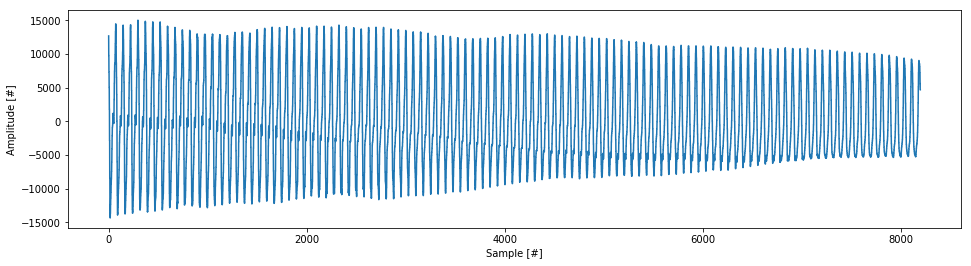

In [12]:
plt.figure(figsize=(16.,4.))
plt.step (range (PARAM_N), sig_slices[5])
plt.xlabel('Sample [#]')
plt.ylabel('Amplitude [#]')
plt.show ()

In [13]:
# WINDOWING
# Hanning window is used
if False:
    from scipy import signal

    # PARAM: type of window
    PARAM_WIN = signal.hann (PARAM_N)
    
    print ('>>> Windowing signal...', end=' ', flush=True)
    for i in range (sig_slices.shape[0]):
        sig_slices[i] = sig_slices[i]*PARAM_WIN
    print ('done')
    plt.figure(figsize=(16.,4.))
    plt.step (range (PARAM_N), sig_slices[5])
    plt.xlabel('Sample [#]')
    plt.ylabel('Amplitude [#]')
    plt.show ()

In [14]:
# ZERO-PADDING
# number of samples of the time-domain signal dictate the resolution in the frequency-domain
if True:
    # PARAM: number of zeros to add
    PARAM_N_ZEROS = 1<<13

    print ('>>> Zero-padding signal...', end=' ', flush=True)
    sig_slices_zpad = np.empty ((sig_slices.shape[0], sig_slices.shape[1]+PARAM_N_ZEROS))
    for i in range (sig_slices.shape[0]):
        sig_slices_zpad[i] = np.append (sig_slices[i], np.full (PARAM_N_ZEROS, 0, dtype=sig_slices[i].dtype))
    sig_slices = sig_slices_zpad
    print ('done')
    print ('[i] New shape of signal slice', sig_slices.shape)

>>> Zero-padding signal... done
[i] New shape of signal slice (26, 16384)


#### Equal Temperament
<a href='https://en.wikipedia.org/wiki/Equal_temperament#General_properties'>Wikipedia: equal temperament</a>

In an equal temperament, the distance between two adjacent steps of the scale is the same interval.

$r^n=p$, $r=\sqrt[\uproot{2}n]{p}$ - ratio r divides the ratio p into n equal parts

#### 12-TET
In twelve-tone equal temperament (12-TET), an octave is divided into 12 equal parts, the width of a semitone.
The frequency ratio of the interval between two adjacent notes, is:

$r=\sqrt[\uproot{2}12]{2}$

To find the frequency, $P_n$, of a note in 12-TET, the following definition may be used:

$P_n = P_a (\sqrt[\uproot{2}12]{2})^{(n-a)}$

$P_n$ is the frequency of the pitch to find, $P_a$ is the frequency of a reference pitch, $n$ and $a$ refer to numbers from a list of consecutive integers assigned to consecutive semitones.

In musical analysis, material belonging to an equal temperament is often given an integer notation, meaning a single integer is used to represent each pitch.

#### Integer notation of pitches
<a href='https://en.wikipedia.org/wiki/Piano'>Piano</a>

Most modern pianos have a row of 88 black and white keys. This means that the piano can play 88 different pitches.

<a href='https://en.wikipedia.org/wiki/Piano_key_frequencies'>Piano key frequencies</a>

A list of the fundamental frequencies in hertz (cycles per second) of the keys of a modern 88-key standard piano in 12-TET, with the 49th key (A4), tuned to 440 Hz (A440).

Insted of taking the piano keys as integer notation, the Scientific Pitch Notation with some minor changes is used.

<a href='https://en.wikipedia.org/wiki/Scientific_pitch_notation'>Scientific pitch notation</a>

(or SPN, also known as American Standard Pitch Notation (ASPN) and International Pitch Notation (IPN)) is a method of specifying musical pitch by combining a musical note name (with accidental if needed) and a number identifying the pitch's octave.

<a href='https://en.wikipedia.org/wiki/Scientific_pitch_notation#Table_of_note_frequencies'>SPN table of note frequencies</a>

<a href='https://en.wikipedia.org/wiki/Twelfth_root_of_two#The_equal-tempered_chromatic_scale'>12-TET chromatic scale</a>

A is always the basis, but notations begin with C.

$C_{-1}$ (note C of ocatve -1) will be the first pitch and noted with 0 as it is defined by MIDI.
From there we create a list of 128 pitch frequencies, up to $G_{9}$ (note G of octave 9, MIDI=128)

Then we are able to choose whatever range we want for further processing (whole range, 88-key Piano, 108-key Piano).

Note A is always the 9th note, and therefor the pitch ratios begin at -9 and end at 2.

In [15]:
pitch_A0 = 27.5
pitch_Ax = np.array ([pitch_A0*(2**n) for n in range (-1, 11)])
twtet_pitch_ratios = np.array ([2**(n*1/12) for n in range (-9, 3)])

twtet_pitches = np.empty ((11,12)) # shape is 11 octaves, each 12 pitches
for i in range (11):
    twtet_pitches[i] = pitch_Ax[i] * twtet_pitch_ratios

twtet_pitches = twtet_pitches.flatten ()
# MIDI notation has only 128 numbers
#twtet_pitches = twtet_pitches[:128]
pitch_C0_midi = 12
twtet_pitches = twtet_pitches[pitch_C0_midi:120]
print ('12-TET pitches')
print ('count:', twtet_pitches.size)
print ('example: A4= {} Hz'.format (twtet_pitches[69-pitch_C0_midi]))

12-TET pitches
count: 108
example: A4= 440.0 Hz


In [16]:
# There will be uncertainty in the Fourier-transformed signal.
# The number of samples of the time-domain signal dictate the resolution in the frequency-domain.
# The frequency-domain is divided evenly in bins (=number of samples).

# TODO
# change numbers to better fit for histogram
# e.g. A0=27.5 > put in bin in half of 12-root-2
#twtet_pitches = twtet_pitches - (2**(1/12)/2)
#print (twtet_pitches)

In [17]:
import scipy
import scipy.fftpack


T = 1.0/sig_prep_fs # sampling interval in time

print ('>>> performing Fourier Transformation...', end=' ', flush=True)
# retrieve Fourier Transform coefficients
# calculate magnitude of the FFT coefficients (= absolute value of each complex coefficient)
sig_fft_mags = np.empty (sig_slices.shape)
for i in range (sig_slices.shape[0]):
    sig_fft_mags[i] = abs (scipy.fft (sig_slices[i]))
print ('done')

# get the frequency bin centers in cycles per unit of the sample spacing (with zero at the start)
freq_bins = list (range (0, len (sig_fft_mags[0])))
# convert bins to frequency range
freq_bins_f = (np.array (freq_bins)/len(sig_fft_mags[0])) * sig_prep_fs

>>> performing Fourier Transformation... done


In [1]:
print ('>>> drawing image...', end=' ', flush=True)
fig, axs = plt.subplots (sig_fft_mags.shape[0], 1, sharex=True)
dpi = fig.get_dpi ()
w = twtet_pitches.size*2
h = twtet_pitches.size*2 #sig_prep_fs/10
fig.set_size_inches (w/dpi,h/dpi)
for i in range (sig_fft_mags.shape[0]):
    cpy = np.copy (sig_fft_mags[i])
    y = []
    for _ in range (25):
        bin_n = np.argmax (cpy)
        y.append (freq_bins_f[bin_n])
        cpy = np.delete (cpy, bin_n)
    hist, edges = np.histogram (y, bins=twtet_pitches, range=(twtet_pitches.min(), twtet_pitches.max()))
    hist=hist[np.newaxis,:]
    extent=[0, twtet_pitches.size,0,1]
    # [!] LATER use cmap="binary"
    axs[i].imshow (hist, aspect='auto', cmap="gray", extent=extent)
    axs[i].axis ('off')
    axs[i].axes.get_xaxis().set_visible (False)
    axs[i].axes.get_yaxis().set_visible (False)

plt.subplots_adjust (top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.savefig (audio_name, dpi=dpi, pad_inches=0, bbox_inches='tight')
plt.show ()

>>> drawing image... 

NameError: name 'plt' is not defined

In [20]:
# IMAGE EDIT: convert to 8 Bit and rotate by 90 degrees
from PIL import Image

img = Image.open (audio_name+'.png').convert ('L')
img = img.rotate (90)
img.save (audio_name+'_bw'+'.png')
#img.show ()

<a href='http://pages.mtu.edu/~suits/notefreqs.html'>http://pages.mtu.edu/~suits/notefreqs.html</a>

## Short-Time Fourier Transformation (STFT)

## simple example for windowing

### cosine wave and its dft

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fs = 1000 # frames per second
T = 1/fs
N = 1000 # samples
n = list (range (0,N))
t = np.linspace (0, len (n)*T, N)
x = [math.cos (2*math.pi*6.5*_t) for _t in t] # cos with freq of 6.5 Hz

# -----

import scipy
import scipy.fftpack

x_zpad = np.append (x, np.full (99000, 0))
X_ZPAD_mags = abs (scipy.fft (x_zpad))
bins = list (range (0, len (x_zpad)))


# -----

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure (figsize=(16.,6.))
plt.subplot (211)
plt.plot (t, x)
plt.title ('time-domain signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [#]')
plt.grid (True)
plt.subplot (212)
plt.plot (bins[0:1500], X_ZPAD_mags[0:1500])
plt.title ('magnitude spectrum of zero-padded signal')
plt.xlabel ('Frequency bin [#]')
plt.ylabel ('Magnitude [#]')
plt.grid (True)

plt.subplots_adjust (hspace=0.5)
plt.show ()

above DFT magnitude spectrum plot shows the first 1500 bins

the frequency with highest magnitude is calculated by:

bin_num / len (x_zpad) \* fs = 650 / 100.000 \* 1.000 = 6.5 Hz

In [ ]:
# now bins will be converted to frequency range
import matplotlib.pyplot as plt
%matplotlib inline

fax = np.array (bins) * fs / len (x_zpad)

plt.figure (figsize=(16.,3.))
plt.plot (fax[0:1500], X_ZPAD_mags[0:1500])
plt.title ('magnitude spectrum of zero-padded signal')
plt.xlabel ('Frequency [Hz]')
plt.ylabel ('Magnitude [#]')
plt.grid (True)

plt.show ()

print ('frequency with highest magnitude = {} Hz'.format (fax[np.argmax(X_ZPAD_mags)]))

### rectangular window

first: look at signals in time-domain

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

Ndisp = 5000

plt.figure (figsize=(16.,6.))
plt.subplot (311)
plt.plot (x_zpad[0:Ndisp])
plt.title ('zero-padded signal' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

t = np.linspace (0, 100000*T, 100000)
sinusoid = [math.cos (2*math.pi*6.5*_t) for _t in t] # cos with freq of 6.5 Hz
plt.subplot (312)
plt.plot (sinusoid[0:Ndisp])
plt.title ('sinusoidal signal' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

win = np.append (np.ones (1000), np.zeros (99000))
plt.subplot (313)
plt.plot (win[0:Ndisp])
plt.title ('rectangular window' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.ylim (-0.5, 1.5)
plt.grid (True)

plt.subplots_adjust (hspace=0.8)
plt.show ()

Interpretation of rectangular window: the sinusoidal signal (graph 2) is multiplied by the rectangular window (graph 3) in order to get the zero-padded signal (graph 1)

second: now let's see how the requency-domain looks like

In [ ]:
fax_dbl_sided = np.copy (fax)

fax_dbl_sided[-49999:] = fax_dbl_sided[-49999:]-1000


plt.figure (figsize=(16.,6.))
plt.subplot (311)
plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (x_zpad))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (x_zpad))[-1000:])
plt.title ('double-sided magnitude spectrum of zero-padded signal')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

plt.figure (figsize=(16.,6.))
plt.subplot (312)
plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (sinusoid))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (sinusoid))[-1000:])
plt.title ('double-sided magnitude spectrum of sinusoidal signal')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

win = np.append (np.ones (1000), np.zeros (99000))
plt.subplot (313)
plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (win))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (win))[-1000:])
plt.title ('double-sided magnitude of rectangular window')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

plt.subplots_adjust (hspace=0.8)
plt.show ()

As shown, the sinusoidal signal is in general just a line in frequency-domain. But due to the applied rectangular window in time-domain, the dft ends up like for the zero-padded signal.

Consequence: **Convolution** = multiplication in time-domain results in convolution in frequency-domain

### hanning window
same as above, nut now with hanning window

In [ ]:
### time-domain signals

from scipy import signal
import scipy.fftpack

import matplotlib.pyplot as plt
%matplotlib inline

Ndisp = 5000

# THIS IS THE IMPORTANT PART - multiply window with time-domain signal
han_win = signal.hann (N)
x_zpad_win = np.append (x*han_win, np.full (99000, 0))

plt.figure (figsize=(16.,6.))
plt.subplot (311)
plt.plot (x_zpad_win[0:Ndisp])
plt.title ('zero-padded signal' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

t = np.linspace (0, 100000*T, 100000)
sinusoid = [math.cos (2*math.pi*6.5*_t) for _t in t] # cos with freq of 6.5 Hz
plt.subplot (312)
plt.plot (sinusoid[0:Ndisp])
plt.title ('sinusoidal signal' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)


plt.subplot (313)
plt.plot (np.append (han_win, np.zeros (99000))[0:Ndisp])
plt.title ('hanning window' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.ylim (-0.5, 1.5)
plt.grid (True)

plt.subplots_adjust (hspace=0.8)
plt.show ()

sinusiodal signal is multiplied with hanning window to get the zero-padded signal (graph 1)

In [ ]:
# frequency-domain signals

from scipy import signal
import scipy.fftpack

import matplotlib.pyplot as plt
%matplotlib inline


X_ZPAD_win_mags = abs (scipy.fft (x_zpad_win))
#bins = list (range (0, len (x_zpad)))


fax_dbl_sided = np.copy (fax)

fax_dbl_sided[-49999:] = fax_dbl_sided[-49999:]-1000


plt.figure (figsize=(16.,6.))
plt.subplot (311)
plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (x_zpad_win))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (x_zpad_win))[-1000:])
plt.title ('double-sided magnitude spectrum of zero-padded signal')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

plt.figure (figsize=(16.,6.))
plt.subplot (312)
plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (sinusoid))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (sinusoid))[-1000:])
plt.title ('double-sided magnitude spectrum of sinusoidal signal')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

plt.subplot (313)

plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (np.append (han_win, np.zeros (99000))))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (np.append (han_win, np.zeros (99000)))[-1000:]))
plt.title ('double-sided magnitude of hanning window')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

plt.tight_layout ()
plt.show ()

## influence of zero-padding
the more zeros padded, the higher the resolution in frequency-domain

since the dft-bins are dictated by the number of samples in time-domain signal

the lower res spectrums are a sampled version of the higher res ones

## deprecated stuff
just for information - messy style

In [ ]:
# read wav file
import wave
import numpy as np

wav_params = None
wav_frames = None
with wave.open (audio_out) as wav_file:
    wav_params = wav_file.getparams ()
    wav_frames = wav_file.readframes (-1)

print ('signal information:')
print ('  channels:', wav_params[0])
print ('  sampling rate: {} Hz (S/s)'.format (wav_params[2]))
print ('  number of samples: {} S'.format (wav_params[3]))
print ('  sample width: {} Bytes = {} Bits'.format (wav_params[1], wav_params[1]*8))
print ('  length of signal: {:.2f} s'.format (wav_params[3]/wav_params[2]))
print ('example of signal samples:')
print ('  ', wav_frames[30000:30010])
wav_frames = np.frombuffer (wav_frames, dtype=np.int16)
print ('  ', wav_frames[30000:30010])
print (wav_frames.dtype)

In [ ]:
# Fourier transformation requires input signal with number of samples to be a power of 2
# if not, zero-pad the signal
# from https://www.geeksforgeeks.org/smallest-power-of-2-greater-than-or-equal-to-n/
if not (sig_prep_N & (sig_prep_N-1) == 0):
    print ('[i] signal length not a power of 2')
    print ('>>> zero-padding the signal...', end=' ', flush=True)
    # get number of zeros to add
    k = sig_prep_N
    while (k&(k-1) > 0):
        k = k&(k-1)
    k = k<<1
    num_zeros = k - sig_prep_N
    # add zeros to end of signal
    sig_prep = np.append (sig_prep, np.full (num_zeros, 0, dtype=sig_prep.dtype))
    sig_prep_N = sig_prep.shape[0]
    sig_prep_len = sig_prep_N/sig_prep_fs
    print ('done')

print (sig_prep_N)
print (sig_prep_len)

---

# Obsolete

## Decode MP3 to WAV
why obsolete: Initial idea was to store mp3 files since they are smaller in size, and then convert them to wav.

In [ ]:
import subprocess
import os


curr_dir = os.path.abspath ('./')
ffmpeg = os.path.join (curr_dir, 'src', 'ffmpeg-20180719-9cb3d8f-win64-static', 'bin', 'ffmpeg.exe')
ffmpeg_opt_main = '-n -i'
ffmpeg_opt_wav = '-ar 44100 -ac 2'
audio_name = "Rick Astley - Never Gonna Give You up"
#"2017-06-16 - CamelPhat, Elderbrook - Cola [Original Mix]"
#"2015-05-29 - Tough Love - So Freakin' Tight [Original Mix]"
audio_in = os.path.join ('src', audio_name + '.mp3')
audio_out = os.path.join ('src', audio_name + '.wav')

cmd = ffmpeg + ' ' + ffmpeg_opt_main + ' ' + \
    "\"" + audio_in + "\"" + ' ' + ffmpeg_opt_wav + ' ' + \
    "\"" + audio_out + "\""

subprocess.call (cmd, shell=True)